**Описание проекта**  
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.  
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.  
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


**Описание данных**
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.
Данные за 2016 год могут быть неполными.

**Шаг 1. Откроем файл с данными и изучим общую информацию**

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import seaborn as sns

In [87]:
games = pd.read_csv('/datasets/games.csv')
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [88]:
games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


In [89]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Оценим процент NaN в столбцах.

In [90]:
games.isnull().sum().sort_values(ascending = False)/games.shape[0]*100

Critic_Score       51.319174
Rating             40.478612
User_Score         40.089740
Year_of_Release     1.609333
Genre               0.011965
Name                0.011965
Other_sales         0.000000
JP_sales            0.000000
EU_sales            0.000000
NA_sales            0.000000
Platform            0.000000
dtype: float64

Столбец Critic_Score. Оценку критиков мы не можем просчитать или восстановить, заполним для удобства NaN произвольным большим числом 9999. Так же поступим со столбцом user_score и приведем его к float. Не забыть == 'tbd', это те же пропуски.

Столбец Year_of_Release содержит пропуски и не является целочисленным, также заполним пропуски произвольным большим числом, а затем - преобразуем к нужному типу.  

In [91]:
rating = pd.read_csv('/datasets/rating.csv')
rating.head()

,rating_type,decryption
0,E,Для всех
1,M,От 17 лет
2,T,Подросткам 13—19 лет
3,E10+,Для всех старше 10 лет
4,K-A,Для всех(до 1998 года)


In [92]:
rating.describe()

,rating_type,decryption
count,8,8
unique,8,8
top,EC,От 17 лет
freq,1,1


In [93]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
rating_type    8 non-null object
decryption     8 non-null object
dtypes: object(2)
memory usage: 256.0+ bytes


**Шаг 2. Подготовим данные**

Заменим названия столбцов (приведем к нижнему регистру).

In [94]:
games.columns = games.columns.str.lower()
games.columns.tolist()

['name',
 'platform',
 'year_of_release',
 'genre',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'critic_score',
 'user_score',
 'rating']

Посмотрим, какие типы данных нужно преобразовать. NaN в столбце Year_of_Release мы не можем заполнить с помощью каких-либо умозаключений, поэтому заполним их каким-нибудь большим числом, преобразуем данные столбца к нужному типу. Так же заполним для удобства большим числом NaN в столбцах critic_score и user_score.

In [95]:
games['year_of_release'] = games['year_of_release'].fillna(9999).astype('int')
games['critic_score']=games['critic_score'].fillna(9999)
games['user_score']=games['user_score'].fillna(9999)

In [96]:
# cols = ['year_of_release','critic_score', 'user_score']
# games[cols] = games[cols].fillna('9999')

Обратим внимание на аббревиатуру 'tbd' в столбцах с рейтингом.

In [98]:
games[games['user_score'] == 'tbd']['user_score'].count()

2424

TBD — сокращение от To Be Determined. Значение не определено, значит, это те же пропуски, поставим вместо них большое число.

In [99]:
games.loc[games['user_score'] == 'tbd','user_score'] = 9999
games['user_score'] = games['user_score'].astype('float')

В текстовых столбцах заполним NaN соответствующими категориями.

In [100]:
games['rating'] = games['rating'].fillna('no rating')
games['genre'] = games['genre'].fillna('no genre')
games['name'] = games['name'].fillna('no name')

Перед проверкой на дубликаты переведем все значения текстовых полей в нижний регистр.

In [101]:
games['name']=games['name'].str.lower()
games['platform']=games['platform'].str.lower()
games['genre']=games['genre'].str.lower()
#games['rating']=games['rating'].str.lower()
#rating['rating_type]=rating['rating_type'].str.lower()
rating['decryption']=rating['decryption'].str.lower()

In [102]:
# string_columns = games.select_dtypes(include='object').columns
# lowercase = lambda x: x.str.lower() if x.name in string_columns

In [103]:
games.duplicated().sum()

0

In [104]:
rating.duplicated().sum()

0

In [105]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16715 non-null object
platform           16715 non-null object
year_of_release    16715 non-null int64
genre              16715 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       16715 non-null float64
user_score         16715 non-null float64
rating             16715 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


Посчитаем количество продаж во всех регионах и запишем в отдельный столбец.

In [106]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,9999.0,9999.0,no rating,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,9999.0,9999.0,no rating,31.38


In [107]:
# sum_list = ['na_sales', 'eu_sales', 'jp_sales']
# games['total_sales'] = games[sum_list].sum(1)
# games.head()

Выполнили предобработку. 

**Шаг 3. Проведем исследовательский анализ данных**

- Посмотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- Возьмем данные за соответствующий актуальный период. Актуальный период определим самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
- Не учитываем в работе данные за предыдущие годы.
- Какие платформы лидируют по продажам, растут или падают? Выберем несколько потенциально прибыльных платформ.
- Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишем результат.
- Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. Сформулируем выводы.
- Соотнесем выводы с продажами игр на других платформах.
- Посмотрим на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Посмотрим, сколько игр выпускалось в разные годы.

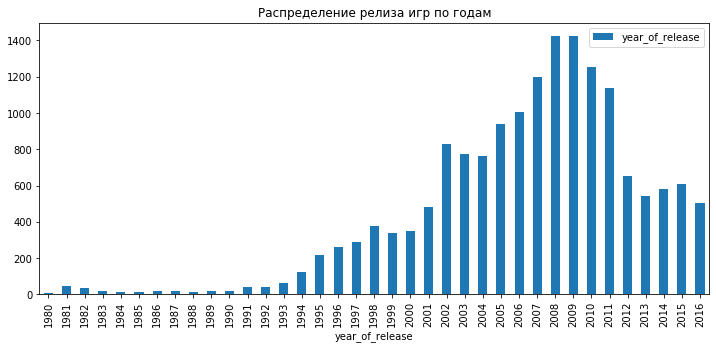

In [108]:
def plot_bar(df, column, title):
    df_not_na = df[df[column] != 9999]
    df_plot = df_not_na.groupby(column)[column].count()
    ax = df_plot.plot(kind='bar', figsize=(12, 5)).legend()
    plt.title(title)
    plt.show()

plot_bar(games, 'year_of_release', 'Распределение релиза игр по годам')


Мы видим, что первые официальные релизы игр появились в 80-х годах, их количество до 90-х годов не превышало определенных значений. Постепенный рост выпуска игр произошел в 90-х, что можно объяснить ростом возможностей операционных систем, массовым распространением ПК среди пользователей. Пик выпуска игр приходится на 2008-2009 годы, далее следует спад, который можно объяснить распределением сферы интересов потребителей игровой индустрии среди прочих гаджетов.

Посмотрим, как менялись продажи по платформам. Выберем платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

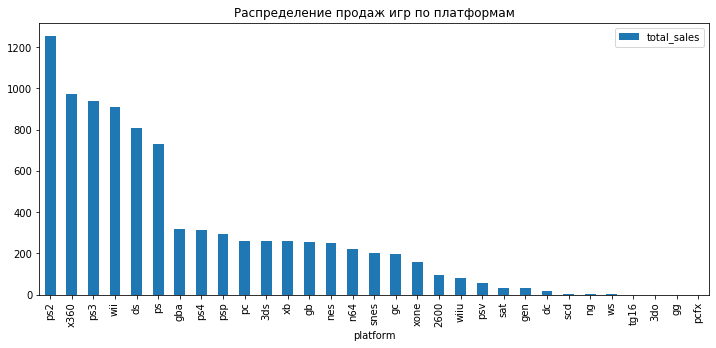

In [109]:
def plot_bar(df, column_gr, column_sum, title):
    df_plot = df.groupby(column_gr)[column_sum].sum().sort_values(ascending = False)
    ax = df_plot.plot(kind='bar', figsize=(12, 5)).legend()
    plt.title(title)
    plt.show()

plot_bar(games, 'platform', 'total_sales', 'Распределение продаж игр по платформам')

Лидером является платформа PS2. Далее идут Xbox360, PS3 и Wii, PS замыкает шестерку явных лидеров.

Выберем топ-6 платформ с наибольшими суммарными продажами и построим распределение по годам.

In [110]:
games_gr=games.pivot_table(index='platform', values = 'total_sales',aggfunc = sum).query('total_sales > 700').sort_values(by = 'total_sales', ascending = False)
print(games_gr)
#head()

          total_sales
platform             
ps2           1255.77
x360           971.42
ps3            939.65
wii            907.51
ds             806.12
ps             730.86


In [111]:
top6 = ['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps']

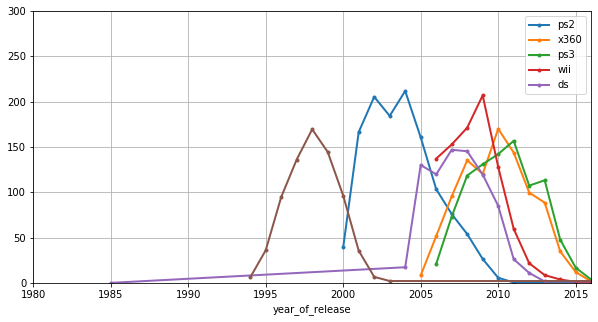

In [112]:
ax = plt.gca()
legend=[]
for platform in top6:
    df_plot = games.query('platform == @platform')
    df_plot.groupby('year_of_release')['total_sales'].sum().plot(x='year_of_release', y='total_sales', xlim=(1980, 2016), ylim=(0, 300), style='.-',grid=True, kind='line', linewidth=2, ax=ax, figsize=(10,5)).legend(legend)
    legend.append(platform)
plt.show()



Игровые платформы имеют жизненный цикл порядка десяти лет. Большинство из них имеют по два пика популярности за всю историю существования, но время идет, появлятся новые платформы, которые вытесняют технически устаревшие консоли.

Возьмем данные за соответствующий актуальный период. Актуальный период определим самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

Актуальным обозначим период в 10 лет - с 2006 года по 2016, большинство игр из нашего топ-6 в это время активно продавались. Построим графики для этого периода.

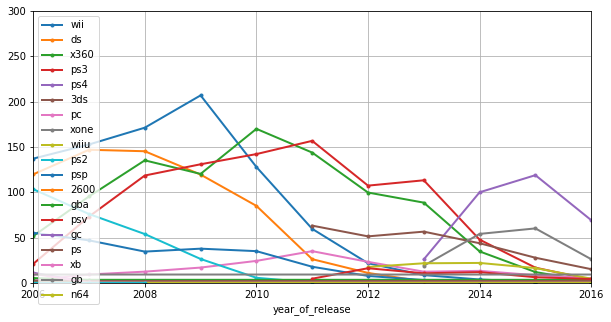

In [113]:
ax = plt.gca()
legend=[]
platform_list=games.query('year_of_release >= 2006')['platform'].unique().tolist()
for platform in platform_list:
    df_plot = games.query('platform == @platform')
    df_plot.groupby('year_of_release')['total_sales'].sum().plot(x='year_of_release', y='total_sales', xlim=(2006, 2016), ylim=(0, 300), style='.-',grid=True, kind='line', linewidth=2, ax=ax, figsize=(10,5)).legend(legend, loc='upper left')
    legend.append(platform)
plt.show()

На конец исследуемого периода мы можем выделить трех лидеров - PS4, Xone и 3DS, на них и следует сделать ставки в 2017 году. Также следует отметить, что продажи по всем играм на конец 2016 снижаются.

Построим график «ящик с усами» по глобальным продажам игр и в разбивке по платформам. Опишем результат.

In [114]:
games.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,16715.000000,16715.000000,16715.000000,16715.000000,16715.000000,16715.000000,16715.000000,16715.000000
mean,2135.110799,0.263377,0.145060,0.077617,0.047342,5164.978283,5461.857858,0.533396
std,1005.781561,0.813604,0.503339,0.308853,0.186731,4963.445816,4974.975363,1.548261
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,71.000000,7.600000,0.060000
50%,2008.000000,0.080000,0.020000,0.000000,0.010000,9999.000000,9999.000000,0.170000
75%,2011.000000,0.240000,0.110000,0.040000,0.030000,9999.000000,9999.000000,0.470000
max,9999.000000,41.360000,28.960000,10.220000,10.570000,9999.000000,9999.000000,82.540000


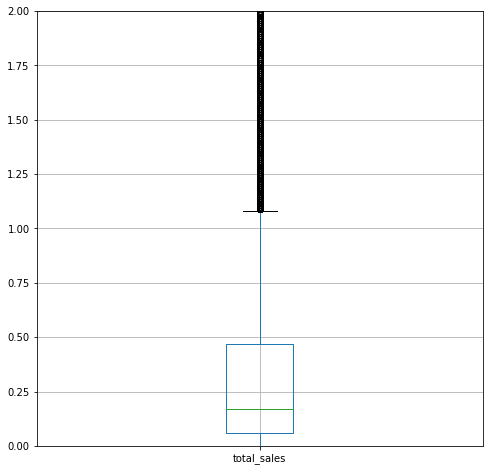

In [115]:
plot = games.boxplot('total_sales', figsize=(8, 8)).set_ylim(0, 2)

Основная совокупность суммарной выручки рынка игр в верхней границе диапазона укладывается в границах 1,1 млн долларов. Медианное значение - 0,17 млн долларов.

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


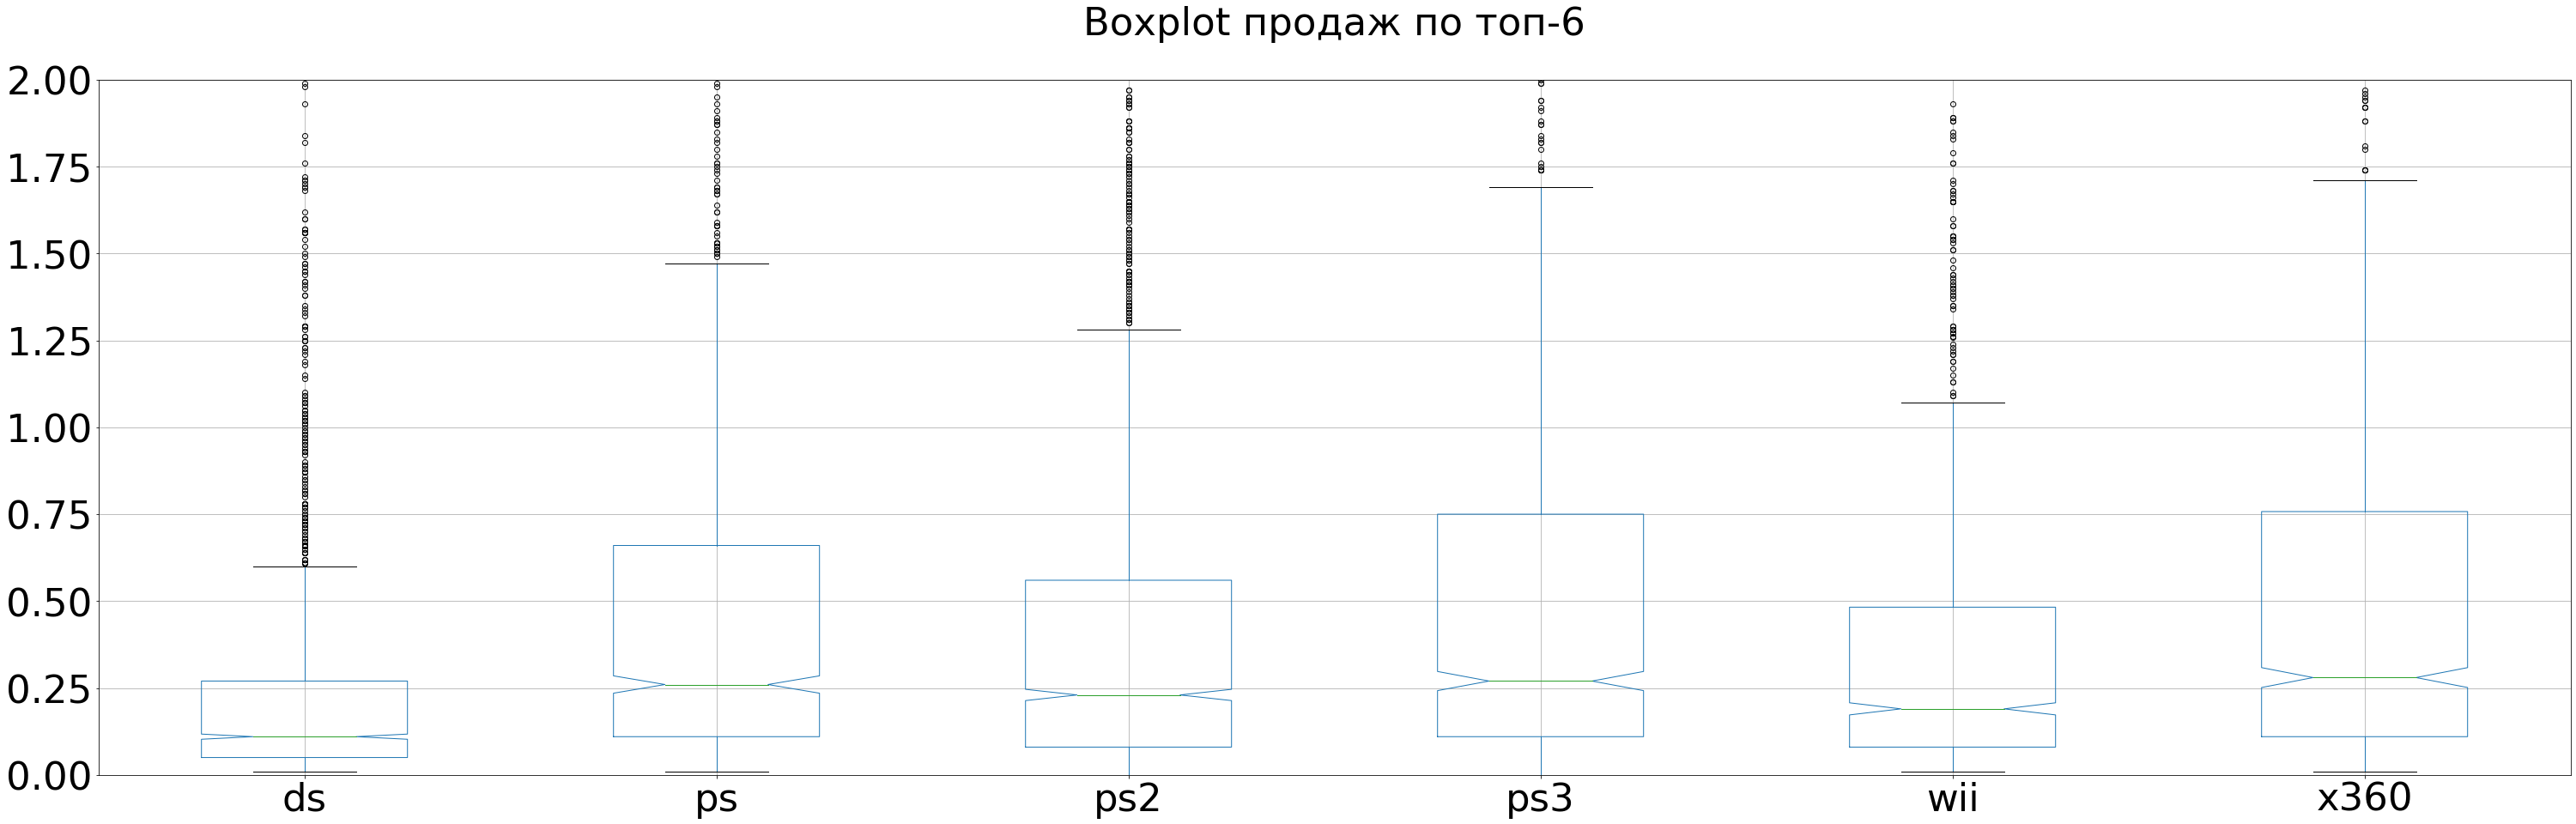

In [116]:
# df_plot = games.query("platform == @top6[@rows+@cols]")

platform_list=['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps']
df_plot = games.query('platform in @platform_list')
ax = df_plot.boxplot(column='total_sales', by='platform', fontsize=45, figsize=(50,15), notch=True)
ax.set_ylim(0, 2)
ax.set_xlabel('')
ax.set_title('')
plt.suptitle("Boxplot продаж по топ-6", fontsize=45)
plt.show()

Медиана значений суммарных продаж игр для платформ из топ-6 принимает значения от 0,1 млн  до 0,25 млн долларов.
Верхняя граница основной совокупности значений у платформ PS3 и X360 заметно выше остальных - на уровне 1,7 млн долларов.
У остальных - от 0,6 до 1,5 миллионов долларов.

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построим диаграмму рассеяния и посчитаем корреляцию между отзывами и продажами. В качестве популярной платформы возьмем X360.

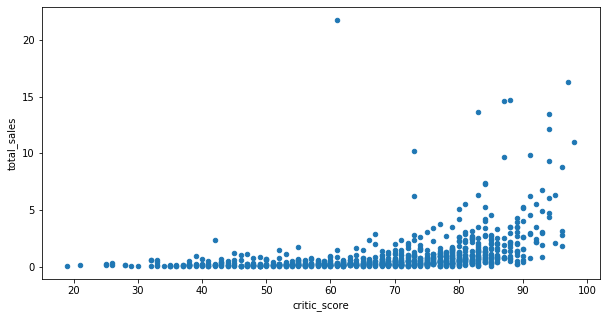

In [117]:
games_x360 = games[(games['platform'] == 'x360') & (games['critic_score'] != 9999)].copy()
games_x360.plot(kind='scatter', x='critic_score', y='total_sales',  figsize=(10,5))

In [118]:
corr = games_x360[['total_sales', 'critic_score']].corr()
corr.style.format("{:.2%}")

,total_sales,critic_score
total_sales,100.00%,39.37%
critic_score,39.37%,100.00%


С ростом рейтинга критиков растет суммарный уровень выручки от продаж игр, связь не такая сильная, но она есть, оба фактора подтверждают качество продукта.

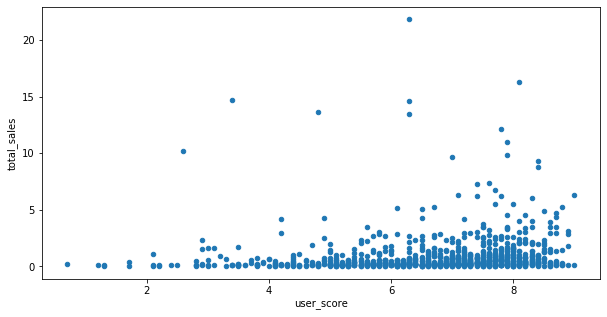

In [119]:
games_x360 = games[(games['platform'] == 'x360') & (games['user_score'] != 9999)].copy()
games_x360.plot(kind='scatter', x='user_score', y='total_sales',  figsize=(10,5))

In [120]:
corr = games_x360[['total_sales', 'user_score']].corr()
corr.style.format("{:.2%}")

,total_sales,user_score
total_sales,100.00%,11.45%
user_score,11.45%,100.00%


Здесь картина аналогичная, с ростом продаж рейтинг отзывов пользователей растет, но связь еще слабее, чем в предыдущем случае, возможно, пользователи, зачастую, чувствуют себя свободнее критиков в плане высказывания собственного мнения.

Соотнесем выводы с продажами игр на других платформах.

In [121]:
games_x360 = games[(games['platform'] == 'x360') & (games['critic_score'] != 9999) & (games['user_score'] != 9999)].copy()

In [122]:
games_ps3_filtered = games_x360[['total_sales' ,'critic_score', 'user_score']]

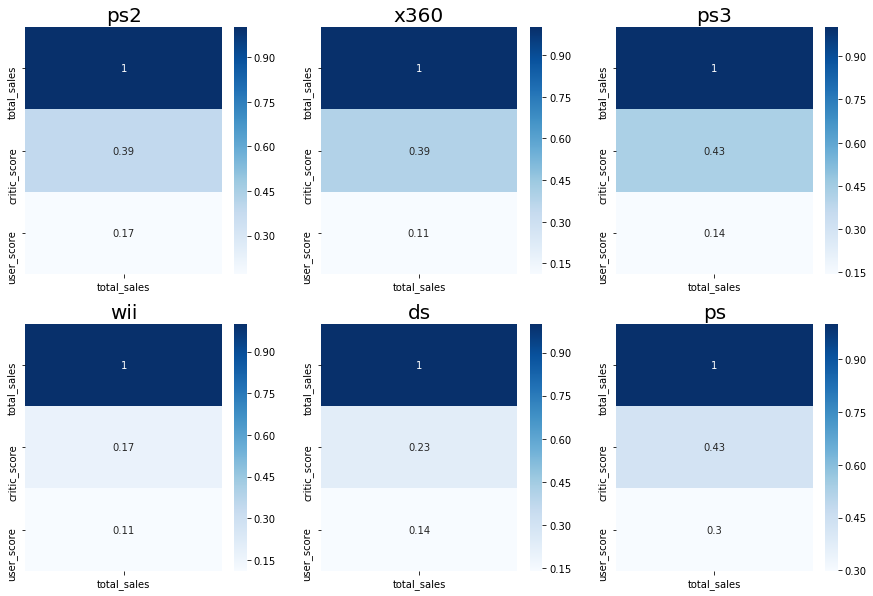

In [123]:
platform_list=['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps']
rows = 2
cols = 3

fig, axes = plt.subplots(rows, cols, figsize=(15,10))
count=0        
for r in range(rows):
    for c in range(cols):
        platform = platform_list[count]
        df_not_na = games[(games['platform'] == platform) & (games['user_score'] != 9999) & (games['critic_score'] != 9999)].copy()
        df_final = df_not_na[['total_sales' ,'critic_score', 'user_score']]
        ax = sns.heatmap(df_final.corr()[['total_sales']].sort_values(by='total_sales', ascending=False), cmap="Blues", 
            annot=True, annot_kws={'size':10}, ax=axes[r,c])
        ax.set_title(platform, fontsize=20)
        count += 1
        

Если рассматривать корреляцию значений суммарных продаж на примере топ-6 платформ, можно заметить, что в большинстве они совпадают с результатами исследования данных по платформе X360. На фоне остальных выделяются платформы wii и ds, их продажи еще менее зависят от мнения критиков.

Посмотрим на общее распределение игр по жанрам.

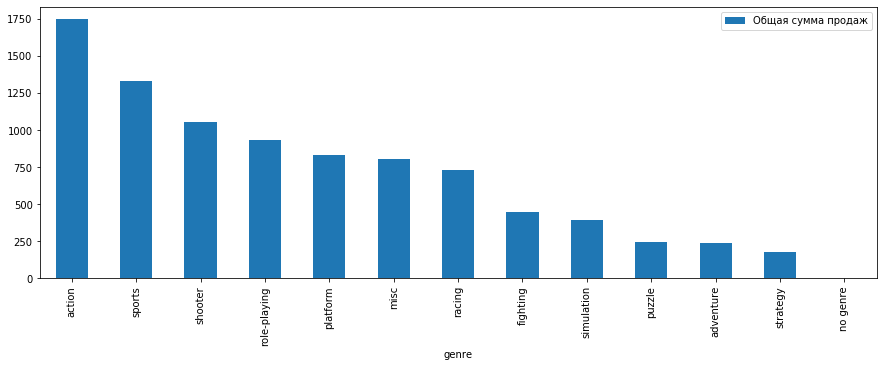

In [124]:
ax = plt.gca()
plot = games.groupby('genre').agg({'total_sales': 'sum'}).sort_values(by='total_sales', ascending=False)
plot = plot['total_sales']
plot.plot(kind='bar', figsize=(15,5), ax=ax)
ax.legend(["Общая сумма продаж"])
plt.show()

Action бесспорный лидер среди жанров.

**Шаг 4. Составим портрет пользователя каждого региона**

Самые популярные платформы (топ-5).

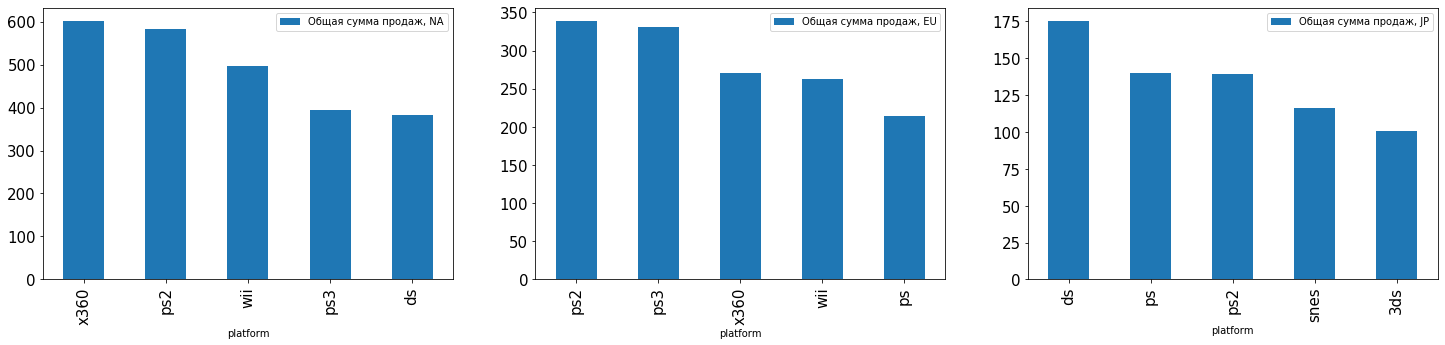

In [125]:
fig, axes = plt.subplots(1, 3, figsize=(25,5))

plot = games.groupby('platform').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head(5).plot(kind='bar', ax=axes[0], fontsize=15).legend(["Общая сумма продаж, NA"])
plot = games.groupby('platform').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head(5).plot(kind='bar', ax=axes[1], fontsize=15).legend(["Общая сумма продаж, EU"])
plot = games.groupby('platform').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head(5).plot(kind='bar', ax=axes[2], fontsize=15).legend(["Общая сумма продаж, JP"])

Самые популярные жанры (топ-5).

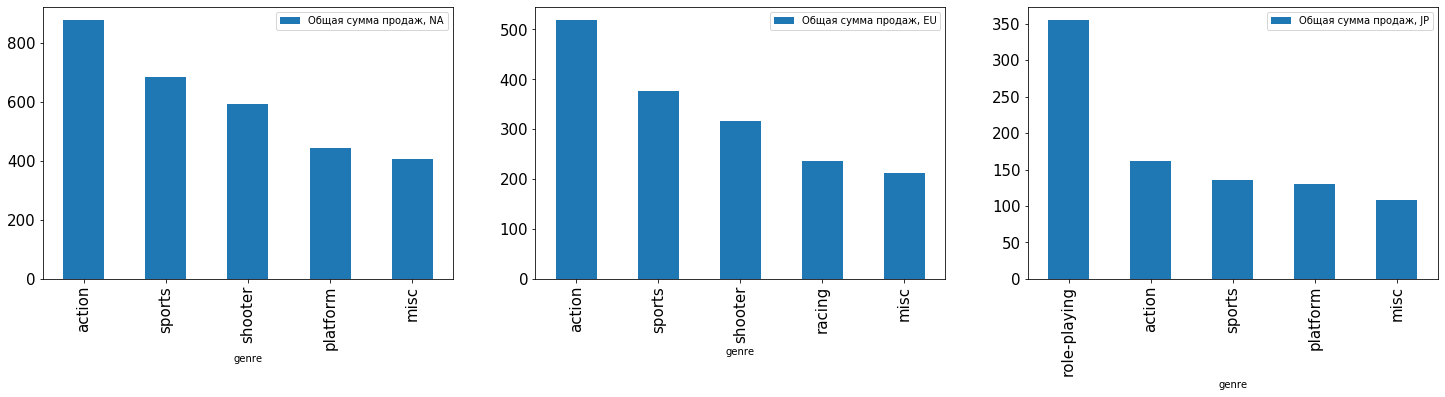

In [126]:
fig, axes = plt.subplots(1, 3, figsize=(25,5))

plot = games.groupby('genre').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head(5).plot(kind='bar', ax=axes[0], fontsize=15).legend(["Общая сумма продаж, NA"])
plot = games.groupby('genre').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head(5).plot(kind='bar', ax=axes[1], fontsize=15).legend(["Общая сумма продаж, EU"])
plot = games.groupby('genre').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head(5).plot(kind='bar', ax=axes[2], fontsize=15).legend(["Общая сумма продаж, JP"])

В Японии выбирают ролевые игры, лидирующие в Европе и Северной Америке жанры action и sports отодвинуты на шаг назад. Жанр shooter замыкает тройки лидеров в Европе и Северной Америке.

Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [127]:
games_copy = games.copy()
games_copy.rename(columns = {'rating':'rating_type'}, inplace = True)
games_copy.head()


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_type,total_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,super mario bros.,nes,1985,platform,29.08,3.58,6.81,0.77,9999.0,9999.0,no rating,40.24
2,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,9999.0,9999.0,no rating,31.38


In [128]:
#left_on = 'tariff' right_on = 'tariff_name'
games_copy = games_copy.merge(rating, on='rating_type', how='right')
games_copy.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating_type,total_sales,decryption
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,для всех
1,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,для всех
2,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,для всех
3,new super mario bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80,для всех
4,wii play,wii,2006,misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91,для всех


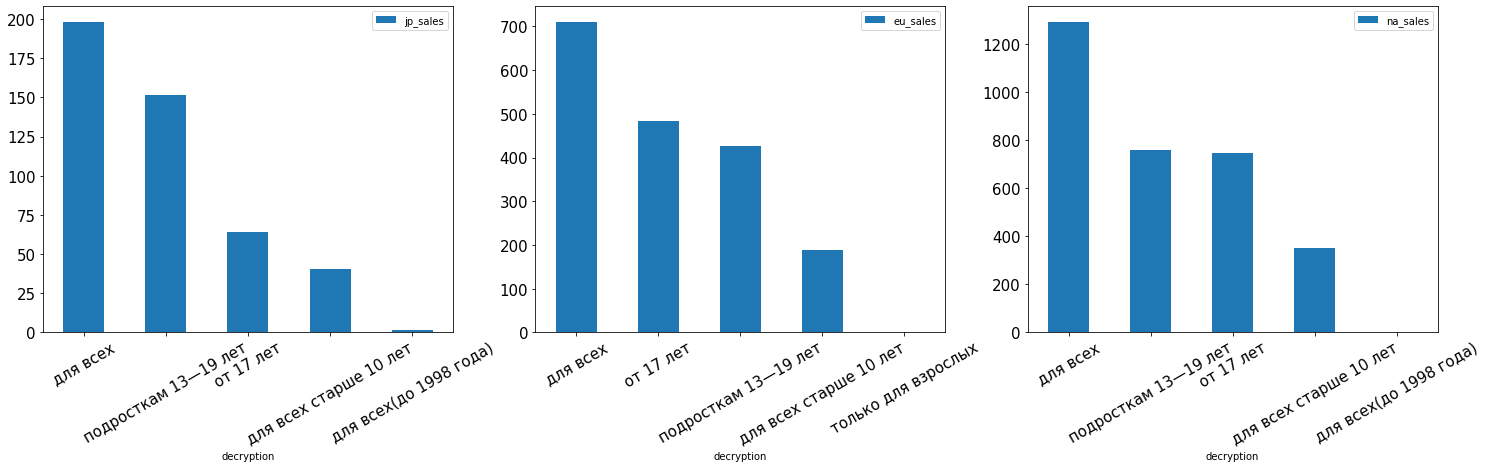

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(25,6))
games_copy.groupby(by='decryption').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False).head(5).plot(kind='bar', ax=axes[0], rot=30, fontsize=15)
games_copy.groupby(by='decryption').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False).head(5).plot(kind='bar', ax=axes[1], rot=30, fontsize=15)
games_copy.groupby(by='decryption').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False).head(5).plot(kind='bar', ax=axes[2], rot=30, fontsize=15)

Категория "для всех" лидирует во всех исследуемых регионах. В Японии аудитория подростков 13-19 представлена гораздо шире, чем в других регионах и идет на втором месте после "для всех". В Европе категория "от 17 лет" занимает второе место, но отрыв от аудитории "подростками 13-19 лет" минимален.

**Шаг 5. Проверьте гипотезы**

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

H0: средний пользовательский рейтинг платформ Xbox One и PC одинаковый  
H1: средний пользовательский рейтинг платформ Xbox One и PC различается

Для проверки обеих гипотез будем использовать t-критерий Стьюдента, так как в обоих случаях выборки независимы между собой.

In [130]:
alpha = 0.05

In [131]:
xbox = games[(games['platform'] == 'xone') & (games['user_score'] > 0) & (games['user_score'] != 9999)]['user_score']
pc = games[(games['platform'] == 'pc') & (games['user_score'] > 0) & (games['user_score'] != 9999)]['user_score']

In [132]:
results = st.ttest_ind(xbox, pc)

In [133]:
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.3896435533548819e-05
Отвергаем нулевую гипотезу


Таким образом, пользовательский рейтинг платформ Xbox One и PC различается.

H0: средний пользовательский рейтинг жанров Action и Sports одинаковый  
H1: средний пользовательский рейтинг жанров Action и Sports различается

In [134]:
action = games[(games['genre'] == 'action') & (games['user_score'] > 0) & (games['user_score'] != 9999)]['user_score']
sports = games[(games['genre'] == 'sports') & (games['user_score'] > 0) & (games['user_score'] != 9999)]['user_score']

In [135]:
results = st.ttest_ind(action, sports)

In [136]:
print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.10406951359049141
Не получилось отвергнуть нулевую гипотезу


Остается верным утверждение, что средние пользовательские рейтинги жанров Action и Sports одинаковые.

В результате проведенного анализа можно сделать выводы о том, что средний срок жизни консоли составляет 10 лет, это следует учитывать при закладке бюджета разработки игр. На конец исследуемого периода мы можем выделить трех консольных лидеров - PS4, Xone и 3DS, на них и следует сделать ставки в 2017 году, однако консоль 3DS подходит к десятилетнему рубежу существования и ее продажи имеют тенденцию к снижению дольше остальных. Также важно отметить, что рынок игр в целом переживает спад, интересы аудитории сместились в сторону более актуальных гаджетов и площадок. Выходя на рынок в том или ином регионе следует учитывать популярнось жанра, платформы в целом, а также активность возрастных категорий аудитории, так как каждый регион имеет свои особенности.

In [137]:
s1 = games[(games['genre'] == 'action') & (games['user_score'] > 0) & (games['user_score'] != 9999)]['user_score']
s2 = games[(games['genre'] == 'sports') & (games['user_score'] > 0) & (games['user_score'] != 9999)]['user_score']

In [150]:
def checkHypothesis(s1, s2, alpha=.05):
    def makeHist(x):
        avg = np.round(x.mean(), 2)
        plt.hist(x)
        plt.title(x.name + ' ' + str(avg))
        plt.show()
    makeHist(s1)
    makeHist(s2)
    #results = st.ttest_ind(s1, s2)
    s1_std = np.std(s1)
    s2_std = np.std(s2)
    std_diff = abs(s1_std/s2_std - 1)
    eq_var = std_diff <= .05
    results = st.ttest_ind(s1, s2, equal_var=eq_var)
    print('p-значение: ', results.pvalue)
    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу, так как различия статистически значимы')
    else:
        print('Нет оснований отвергнуть нулевую гипотезу')
    
    if eq_var:
        print('дисперсия выборок < 5 %::',eq_var)
    else:
        print('дисперсия выборок > 5 %:', std_diff)

In [151]:
s1.name = 'action'
s2.name = 'sports'

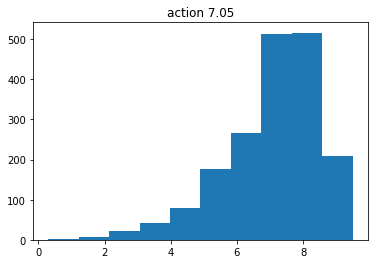

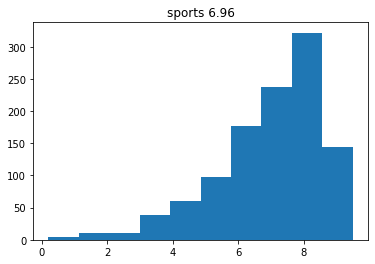

p-значение:  0.11483818791498286
Нет оснований отвергнуть нулевую гипотезу
дисперсия выборок > 5 %: 0.11525590017803122


In [152]:
checkHypothesis(s1, s2)